In [1]:
!pip install pycaret

# Introducción y carga de datos

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import warnings
# Preprocesado
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
# Regresión logística
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Grid search
from sklearn.model_selection import GridSearchCV
# Explicabilidad
import shap
# AutoML
from pycaret.classification import setup


Carga datos de dataset

Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
Tras observar los datos de un día dado, el objetivo es predecir las variables target:

- RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.

In [9]:
df = pd.read_csv('weatherAUS.csv')
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


In [10]:
len(df)

145460

Seleccionamos 10 ciudades aleatoriamente.

In [11]:
# Semilla para reproducibilidad
random.seed(42)
ciudades = random.sample(df["Location"].unique().tolist(), 10)
ciudades

['Perth',
 'NorfolkIsland',
 'BadgerysCreek',
 'MountGinini',
 'Canberra',
 'Wollongong',
 'Penrith',
 'NorahHead',
 'Nuriootpa',
 'Newcastle']

Veamos los tipos y la cantidad de observaciones.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Vemos que tenemos 22 variables, de las cuales 16 son numéricas, 5 categóricas y fecha será de tipo date. Por otro lado, tenemos la variable Location, que eliminaremos a continuación.

Droppeamos los valores faltantes para la variable objetivo. El resto de valores nulos serán tratados más adelante.

In [13]:
df = df.dropna(subset=['RainTomorrow']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [14]:
df = df[df["Location"].isin(ciudades)].reset_index(drop=True).drop(columns=["Location"])
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Análisis exploratorio y selección de características

## Visualización de los datos

Hechemos un vistazo a los datos que contiene nuestro dataframe.

In [15]:
df_train.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
24560,2010-05-29,9.5,12.9,12.0,1.0,3.2,W,69.0,W,WSW,...,91.0,89.0,1008.7,1009.8,6.0,8.0,9.6,12.2,Yes,Yes
16432,2013-11-23,17.8,22.3,6.8,NaN,NaN,N,33.0,SSE,E,...,85.0,81.0,1005.7,1003.6,NaN,4.0,19.8,20.9,Yes,No
4400,2013-04-13,14.2,25.5,0.0,NaN,NaN,NaN,NaN,NaN,SE,...,91.0,64.0,NaN,NaN,5.0,1.0,17.0,24.2,No,No
8604,2016-11-30,19.2,25.6,0.0,NaN,NaN,N,63.0,S,E,...,70.0,67.0,1012.6,1010.0,NaN,NaN,22.9,24.3,No,No
7261,2013-01-21,19.9,26.8,3.6,NaN,NaN,ENE,22.0,SSW,ENE,...,82.0,66.0,1015.8,1013.8,NaN,NaN,24.0,25.8,Yes,No


Identificamos los tipos de datos de cada columna, y la cantidad de datos faltantes en cada columna, comparándolo con el tamaño del dataframe.

In [16]:
df_train.info()
print("\nTamaño del dataframe:")
df_train.shape

<class 'pandas.core.frame.DataFrame'>
Index: 24194 entries, 24560 to 23654
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           24194 non-null  object 
 1   MinTemp        23874 non-null  float64
 2   MaxTemp        24042 non-null  float64
 3   Rainfall       23917 non-null  float64
 4   Evaporation    8526 non-null   float64
 5   Sunshine       8093 non-null   float64
 6   WindGustDir    21341 non-null  object 
 7   WindGustSpeed  21356 non-null  float64
 8   WindDir9am     21399 non-null  object 
 9   WindDir3pm     22708 non-null  object 
 10  WindSpeed9am   23627 non-null  float64
 11  WindSpeed3pm   23123 non-null  float64
 12  Humidity9am    23563 non-null  float64
 13  Humidity3pm    23185 non-null  float64
 14  Pressure9am    16839 non-null  float64
 15  Pressure3pm    16868 non-null  float64
 16  Cloud9am       12322 non-null  float64
 17  Cloud3pm       11203 non-null  float64
 18  Temp9am

(24194, 22)

Algunas medidas de resumen de las variables numéricas de datos.

In [17]:
df_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,23874.000000,24042.000000,23917.000000,8526.000000,8093.000000,21356.000000,23627.000000,23123.000000,23563.000000,23185.000000,16839.000000,16868.000000,12322.000000,11203.000000,23677.000000,23269.000000
mean,11.651525,21.830634,2.601238,4.998053,7.789374,39.697649,12.244551,17.044069,71.859950,56.283071,1018.273484,1015.980318,4.531245,4.551370,16.173561,20.311634
std,6.317636,6.875519,8.445802,3.337659,3.662865,14.486898,9.182497,9.346625,17.722962,20.554315,6.849742,6.691395,2.862065,2.700936,6.082453,6.695757
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,2.000000,982.000000,985.500000,0.000000,0.000000,-7.200000,-5.400000
25%,7.500000,17.900000,0.000000,2.600000,5.300000,30.000000,6.000000,9.000000,60.000000,41.000000,1013.800000,1011.500000,1.000000,2.000000,12.400000,16.600000
50%,12.400000,21.700000,0.000000,4.200000,8.500000,37.000000,11.000000,17.000000,73.000000,56.000000,1018.300000,1016.000000,5.000000,5.000000,16.800000,20.200000
75%,16.600000,25.800000,0.800000,6.800000,10.600000,48.000000,17.000000,22.000000,85.000000,71.000000,1022.900000,1020.500000,7.000000,7.000000,20.600000,24.200000
max,29.700000,46.900000,216.300000,74.800000,14.300000,135.000000,130.000000,83.000000,100.000000,100.000000,1040.200000,1037.800000,9.000000,8.000000,39.000000,46.200000


## Gráficos univariados

Graficamos las diferentes variables del dataframe, para dar un primer pantallazo de nuestro datos, y a su vez, chequeamos el balanceo de las variables.

### Variable objetivo - RainTomorrow

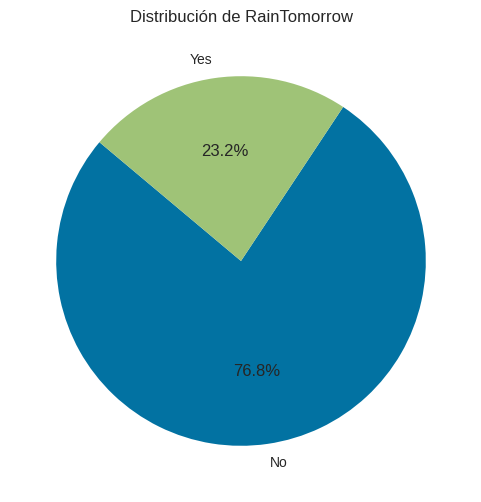

In [18]:
rain_counts = df_train['RainTomorrow'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(rain_counts, labels=rain_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de RainTomorrow')
plt.show()

Vemos que hay una proporción de 3 a 1 en la variable objetivo, lo cual significa que está desbalanceada. Este problema debe ser considerado a la hora de entrenar al modelo para evitar que se limite a predecir la categoría dominante.

### Lluvia

Buscamos predecir si lloverá un día con los datos de días anteriores. Para esto, es vital que conozcamos cómo se ven estos datos:

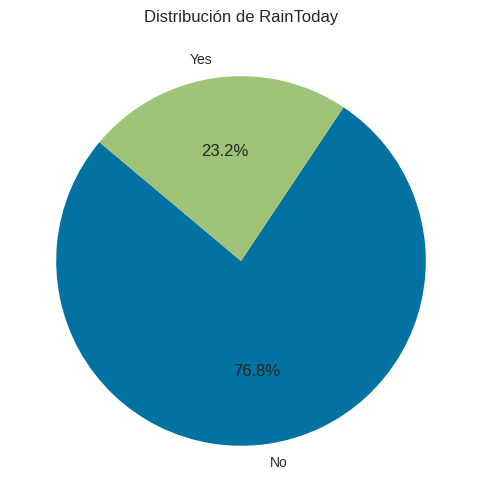

In [19]:
rain_counts = df_train['RainToday'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(rain_counts, labels=rain_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de RainToday')
plt.show()

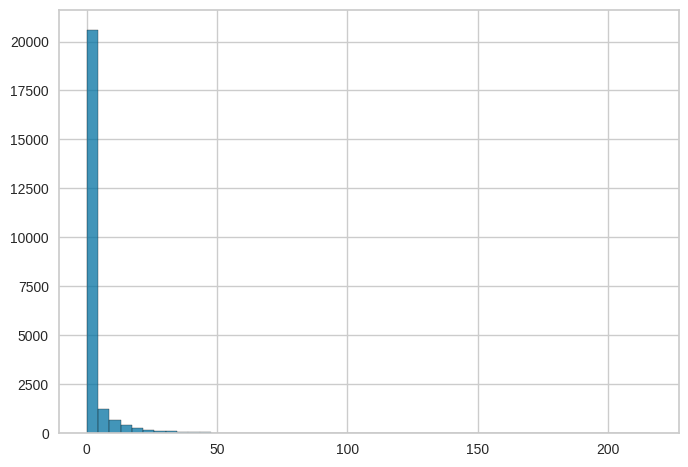

In [20]:
plt.hist(df_train.dropna(subset=['Rainfall'])['Rainfall'], bins=50, edgecolor='k', alpha=0.75)
plt.show()

In [21]:
df_train["Rainfall"].describe()

,Rainfall
count,23917.000000
mean,2.601238
std,8.445802
min,0.000000
25%,0.000000
50%,0.000000
75%,0.800000
max,216.300000


Vemos que tiene una distribución de forma exponencial, con la mayoría de sus valores en 0 (hasta el 3er cuartil, los valores son 0). Esto puede explicarse ya que la mayoría de días no hubo lluvia. Es más, en el anterior gráfico, vimos que el 77% de los días no llovió, por lo que estos resultados son de esperar.

### Velocidad del Viento

Procedemos a graficar otras variables, para conocer cómo se ve nuestra base de datos.

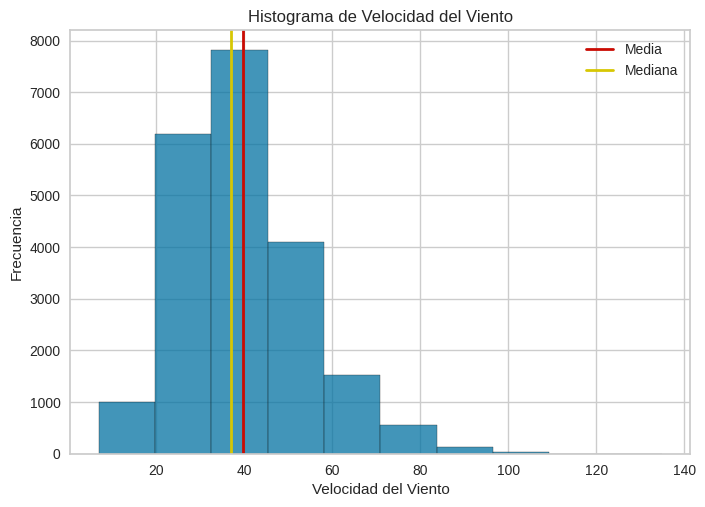

In [22]:
plt.hist(df_train['WindGustSpeed'], bins=10, edgecolor='k', alpha=0.75)
plt.axvline(df_train['WindGustSpeed'].mean(), color='r', linewidth=2)
plt.axvline(df_train['WindGustSpeed'].median(), color='y', linewidth=2)
plt.legend(['Media', 'Mediana'])
plt.xlabel('Velocidad del Viento')
plt.ylabel('Frecuencia')
plt.title('Histograma de Velocidad del Viento')
plt.show()

Vemos que la variable tiene una distribución aproximadamente normal y levemente asimétrica hacia la derecha.

### Nubes

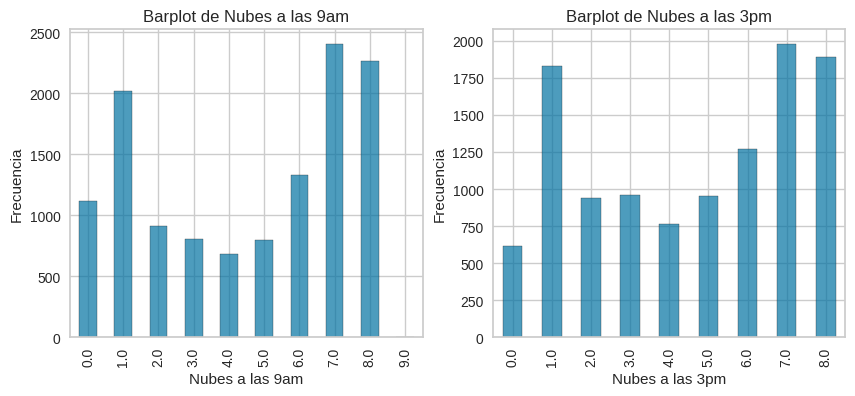

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df_train['Cloud9am'].value_counts().sort_index().plot(kind="bar", ax=axes[0], edgecolor='k', alpha=0.7)
axes[0].set_xlabel('Nubes a las 9am')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Barplot de Nubes a las 9am')

df_train['Cloud3pm'].value_counts().sort_index().plot(kind="bar", ax=axes[1], edgecolor='k', alpha=0.7)
axes[1].set_xlabel('Nubes a las 3pm')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Barplot de Nubes a las 3pm')

plt.show()


Al ser dos variables similares, es de esperar que sus distribuciones también lo sean, como se puede observar. Por otro lado, esperamos que estén altamente correlacionadas, pero no tiene por qué ser el caso con simplemente ver los gráficos.

A pesar de que inicialmente se importó como float64, la variable es numérica discreta.

### Presión

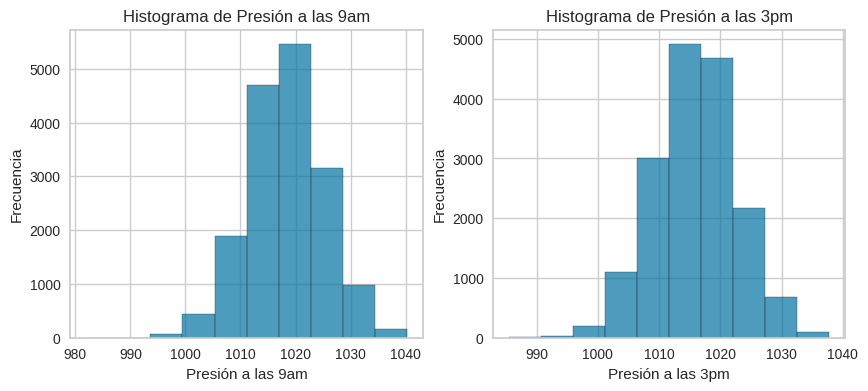

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df_train['Pressure9am'].plot.hist(ax=axes[0], bins=10, edgecolor='k', alpha=0.7)
axes[0].set_xlabel('Presión a las 9am')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Histograma de Presión a las 9am')

df_train['Pressure3pm'].plot.hist(ax=axes[1], bins=10, edgecolor='k', alpha=0.7)
axes[1].set_xlabel('Presión a las 3pm')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Histograma de Presión a las 3pm')

plt.show()

Nuevamente, tenemos que estas dos variables similares tienen una distribución casi idéntica.

### Temperatura mínima y máxima

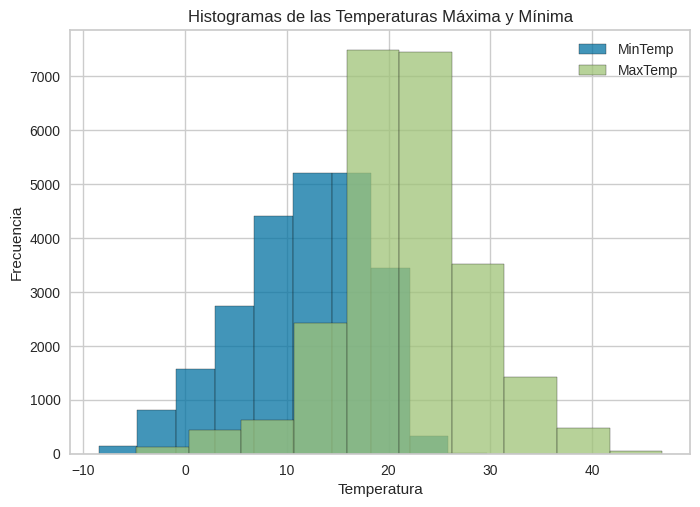

In [25]:
plt.hist(df_train['MinTemp'], bins=10, edgecolor='k', alpha=0.75, label='MinTemp')
plt.hist(df_train['MaxTemp'], bins=10, edgecolor='k', alpha=0.75, label='MaxTemp')
plt.xlabel('Temperatura')
plt.ylabel('Frecuencia')
plt.title('Histogramas de las Temperaturas Máxima y Mínima')
plt.legend()
plt.show()

Vemos que la temperatura mínima y máxima siguen distribuciones aproximadamente normales, la primera asimétrica hacia la izquierda y la segunda hacia la derecha. Además podemos observar que, como es esperable, el rango de valores de estas están "desplazados" en el eje.

### Dirección del viento

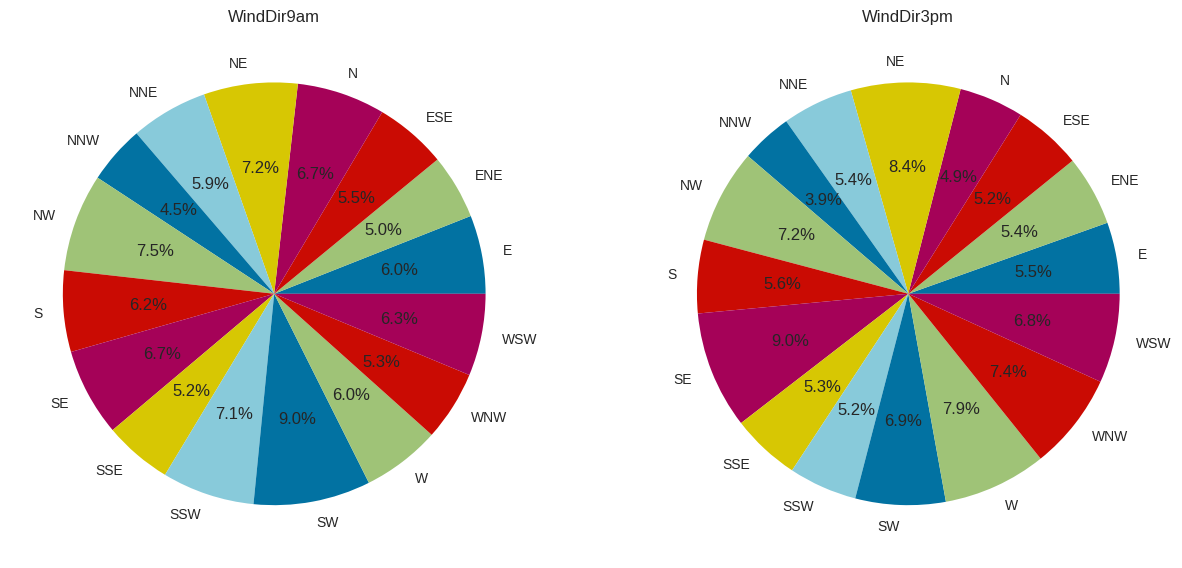

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

df_train["WindDir9am"].value_counts().sort_index().plot(kind="pie", autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('WindDir9am')
axes[0].set_ylabel('')

df_train["WindDir3pm"].value_counts().sort_index().plot(kind="pie", autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('WindDir3pm')
axes[1].set_ylabel('')

plt.show()

Vemos que la dirección del viento en ambos casos es una variable distribuida de manera casi equitativa, no habiendo ninguna clase con una frecuencia demasiado alta o baja.

## Gráficos bivariados

Veamos cómo afecta la presencia de nubes a la probabilidad de lluvia al día siguiente.

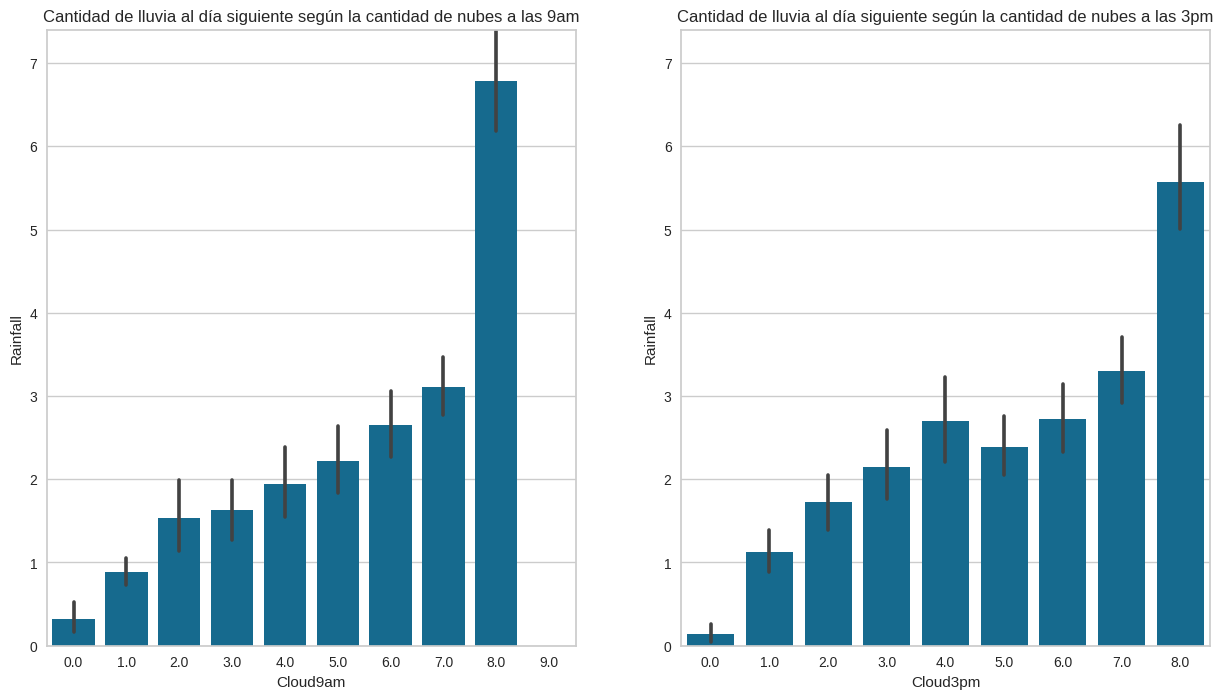

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.barplot(x='Cloud9am', y='Rainfall', ax=axes[0], data=df_train)
axes[0].set_ylim(0, 7.4)
axes[0].set_title('Cantidad de lluvia al día siguiente según la cantidad de nubes a las 9am')

sns.barplot(x='Cloud3pm', y='Rainfall', ax=axes[1], data=df_train)
axes[1].set_ylim(0, 7.4)
axes[1].set_title('Cantidad de lluvia al día siguiente según la cantidad de nubes a las 3pm')
plt.show()

Estas variables tienen una aparentemente alta correlación: A medida que aumenta la cantidad de nubes, la cantidad de lluvia observada incrementa.

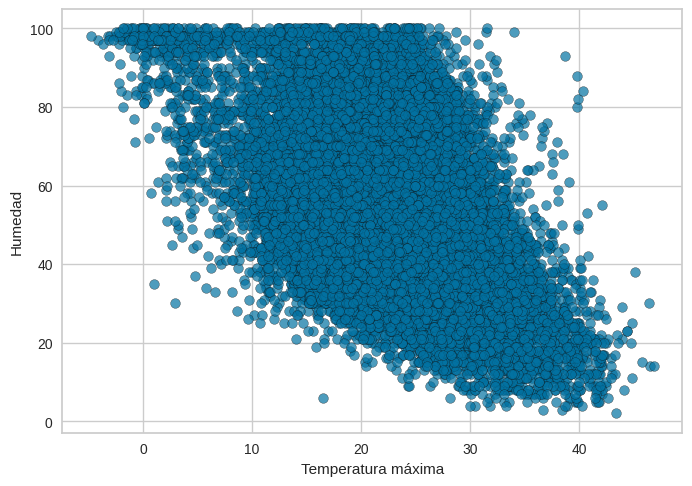

In [28]:
# evaporation y maxtemp
plt.scatter(df_train['MaxTemp'], df_train['Humidity3pm'], edgecolor='k', alpha=0.7)
plt.xlabel("Temperatura máxima")
plt.ylabel('Humedad')
plt.show()


Vemos una tendencia decreciente en la humedad a medida que la temperatura incrementa.

# Limpieza de los datos

## Codificación de variables categóricas

#### Codificamos RainToday y RainTomorrow

In [29]:
code_lluvia = {"Yes":1, "No":0}

df_train['RainToday'] = df_train["RainToday"].map(code_lluvia)
df_train['RainTomorrow'] = df_train["RainTomorrow"].map(code_lluvia)

# Lo hacemos en el df de test
df_test['RainToday'] = df_test["RainToday"].map(code_lluvia)
df_test['RainTomorrow'] = df_test["RainTomorrow"].map(code_lluvia)

Veamos si existe algún desbalanceo en los datos:

### Balanceo y formatteo de fechas

Balanceo de los años

<Axes: xlabel='Year'>

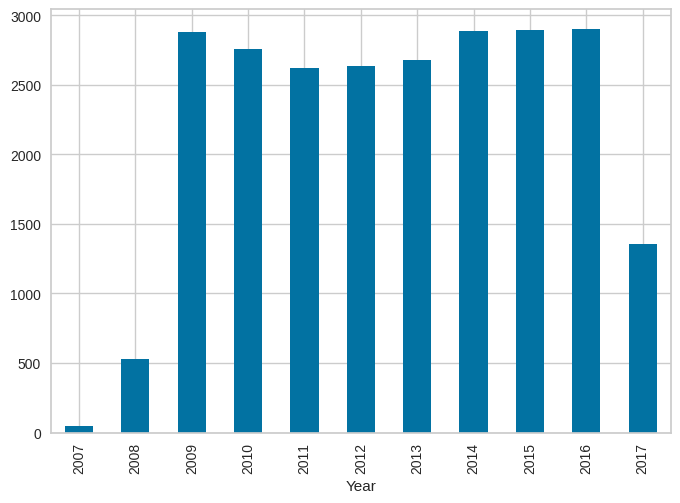

In [30]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
nbins = len(df_train["Year"].unique())
df_train['Year'].value_counts().sort_index().plot(kind="bar")

# Hacemos lo mismo en el dataset de test
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test["Year"] = df_test["Date"].dt.year
df_test["Month"] = df_test["Date"].dt.month
df_test['Year'].value_counts().sort_index().plot(kind="bar")

<Axes: xlabel='Year'>

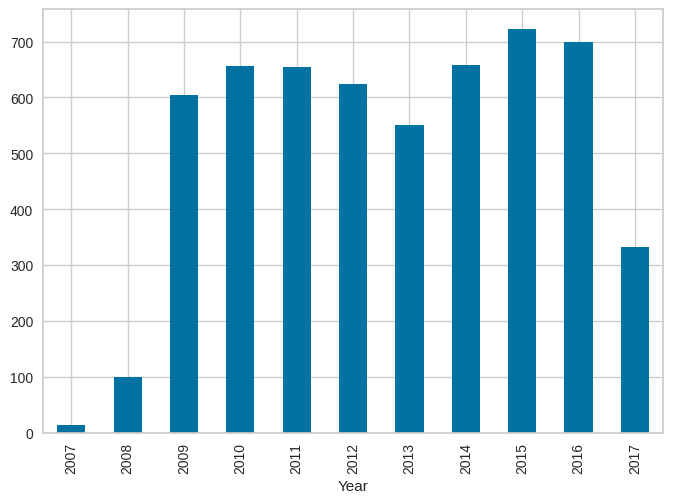

In [31]:
df_train[df_train["RainTomorrow"]==1]["Year"].value_counts().sort_index().plot(kind="bar")

Se puede observar que la variable Year no tiene una relevancia mayor en la cantidad de días de lluvia, ya que se puede ver que el barplot es muy similar al anteriomente visto, lo cual nos dice que la cantidad de lluvia en un año depende realmente casi exclusivamente de la cantidad de datos que tengamos del mismo.

Por lo tanto, no consideramos esta variable de relevancia y se la omitirá.

In [32]:
df_train = df_train.drop(columns=["Year"])

# Hacemos lo mismo en el dataset de test
df_test = df_test.drop(columns=["Year"])

Balanceo de los meses

<Axes: xlabel='Month'>

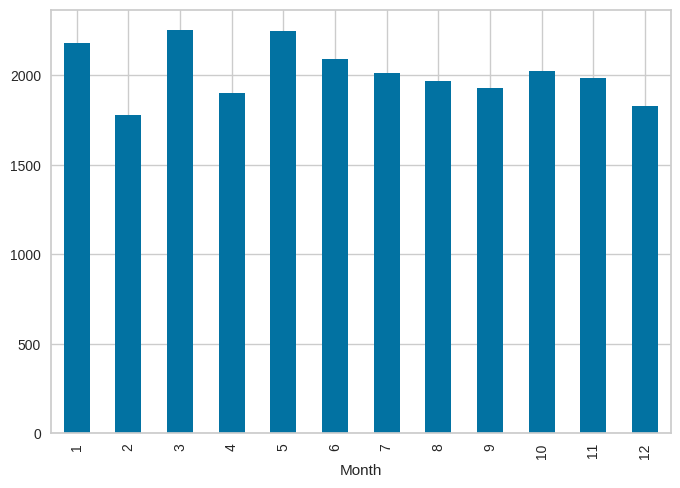

In [33]:
df_train['Month'].value_counts().sort_index().plot(kind="bar")

Observamos que existe un buen balanceo de los años y los meses.

Ahora, podemos finalmente codificar fecha

In [34]:
# get dummies de mes
df_train = pd.get_dummies(df_train, columns=['Month'], drop_first=True, dtype='int8')

# Hacemos lo mismo en el dataset de test
df_test = pd.get_dummies(df_test, columns=['Month'], drop_first=True, dtype='int8')

### Balanceo y formatteo de la dirección del viento

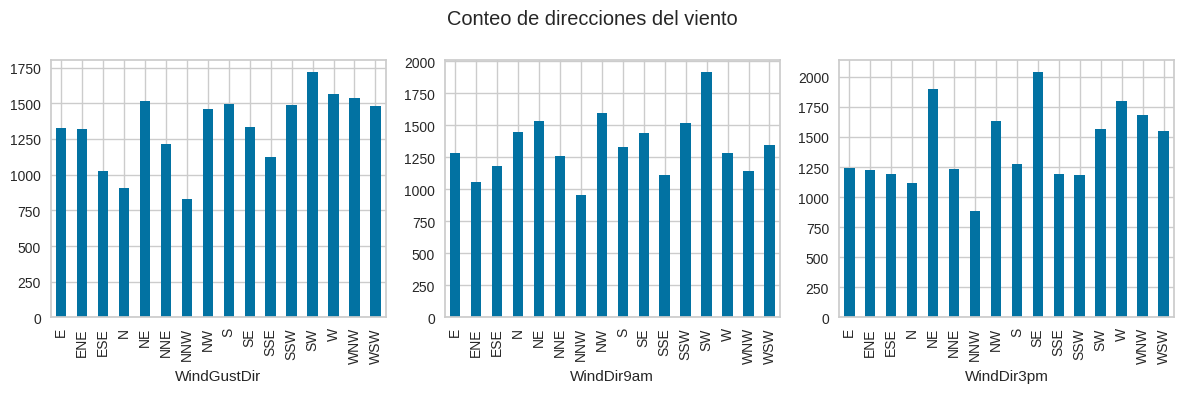

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 fila y 3 columnas para los gráficos

df_train['WindGustDir'].value_counts().sort_index().plot(kind="bar", ax=axes[0])
df_train['WindDir9am'].value_counts().sort_index().plot(kind="bar", ax=axes[1])
df_train['WindDir3pm'].value_counts().sort_index().plot(kind="bar", ax=axes[2])

axes[0].set_xlabel('WindGustDir')
axes[1].set_xlabel('WindDir9am')
axes[2].set_xlabel('WindDir3pm')
fig.suptitle('Conteo de direcciones del viento')

plt.tight_layout()
plt.show()

#### Codificamos la dirección del viento


Pudimos observar que la dirección del viento está relativamente balanceada. Creamos una nueva representacion numérica del viento, y dos columnas para esta nueva representación.

In [36]:
WindDirToXDir = {
    'N': 0,
    'S': 0,
    'E': 1,
    'W': -1,
    'NW': 2**0.5,
    'NE': -2**0.5,
    'SE': 2**0.5,
    'SW': -2**0.5,
    'NNW': np.cos(5*np.pi/8),
    'NNE': np.cos(3*np.pi/8),
    'ENE': np.cos(1*np.pi/8),
    'WNW': np.cos(7*np.pi/8),
    'ESE': np.cos(-1*np.pi/8),
    'SSE': np.cos(-3*np.pi/8),
    'SSW': np.cos(-5*np.pi/8),
    'WSW': np.cos(-7*np.pi/8)
}
WindDirToYDir = {
    'N': 1,
    'S': -1,
    'E': 0,
    'W': 0,
    'NW': 2**0.5,
    'NE': 2**0.5,
    'SE': -2**0.5,
    'SW': -2**0.5,
    'NNW': np.sin(3*np.pi/8),
    'NNE': np.sin(3*np.pi/8),
    'ENE': np.sin(1*np.pi/8),
    'WNW': np.sin(1*np.pi/8),
    'ESE': np.sin(-1*np.pi/8),
    'SSE': np.sin(-3*np.pi/8),
    'SSW': np.sin(-3*np.pi/8),
    'WSW': np.sin(-1*np.pi/8)
}

df_train['WindDir3pmX'] = df_train['WindDir3pm'].map(WindDirToXDir)
df_train['WindDir3pmY'] = df_train['WindDir3pm'].map(WindDirToYDir)

df_train['WindDir9amX'] = df_train['WindDir9am'].map(WindDirToXDir)
df_train['WindDir9amY'] = df_train['WindDir9am'].map(WindDirToYDir)

df_train['WindGustDirX'] = df_train['WindGustDir'].map(WindDirToXDir)
df_train['WindGustDirY'] = df_train['WindGustDir'].map(WindDirToYDir)

df_train = df_train.drop(columns=['WindDir3pm'])
df_train = df_train.drop(columns=['WindDir9am'])
df_train = df_train.drop(columns=['WindGustDir'])

# Hacemos lo mismo en el dataset de test
df_test['WindDir3pmX'] = df_test['WindDir3pm'].map(WindDirToXDir)
df_test['WindDir3pmY'] = df_test['WindDir3pm'].map(WindDirToYDir)

df_test['WindDir9amX'] = df_test['WindDir9am'].map(WindDirToXDir)
df_test['WindDir9amY'] = df_test['WindDir9am'].map(WindDirToYDir)

df_test['WindGustDirX'] = df_test['WindGustDir'].map(WindDirToXDir)
df_test['WindGustDirY'] = df_test['WindGustDir'].map(WindDirToYDir)

df_test = df_test.drop(columns=['WindDir3pm'])
df_test = df_test.drop(columns=['WindDir9am'])
df_test = df_test.drop(columns=['WindGustDir'])

### Droppeamos variable Date

Finalmente, eliminamos la variable date, pues no estaremos analizando los datos como una serie temporal.

In [37]:
df_train.drop(columns=["Date"], inplace=True)
df_test.drop(columns=["Date"], inplace=True)

## Imputación de datos faltantes

Veamos la cantidad de valores faltantes.

In [38]:
df_train.isna().sum()

,0
MinTemp,320
MaxTemp,152
Rainfall,277
Evaporation,15668
Sunshine,16101
WindGustSpeed,2838
WindSpeed9am,567
WindSpeed3pm,1071
Humidity9am,631
Humidity3pm,1009


Vemos que hay valores faltantes en la variable `RainToday`, pero no los hay para `RainTomorrow`. Por lo tanto, podemos utilizar la información del día anterior para obtener si llovió o no

In [39]:
# Crear una columna temporal con los valores de RainTomorrow desplazados una posición hacia arriba
df_train['RainTomorrow_shifted'] = df_train['RainTomorrow'].shift(1)

# Llenar los valores faltantes en RainToday con los valores de RainTomorrow desplazados
df_train['RainToday'] = df_train['RainToday'].fillna(df_train['RainTomorrow_shifted'])

# Eliminar la columna temporal si ya no es necesaria
df_train = df_train.drop(columns=['RainTomorrow_shifted'])

# Hacemos lo mismo para el conjunto de test
df_test['RainTomorrow_shifted'] = df_test['RainTomorrow'].shift(1)
df_test['RainToday'] = df_test['RainToday'].fillna(df_test['RainTomorrow_shifted'])
df_test = df_test.drop(columns=['RainTomorrow_shifted'])

In [40]:
df_train['RainToday'].isna().sum()

0

Debido a que hay una gran cantidad de datos faltantes, además distribuidos entre diversas variables, eliminarlos significaría una pérdida significativa de información para nuestro modelo.

Por lo tanto, haremos inputación de datos. Utilizaremos KNN ya que probó tener una buena performance en el anterior trabajo práctico.

In [41]:
imputer = KNNImputer(n_neighbors=5)

df_train_imputed = imputer.fit_transform(df_train)

df_train = pd.DataFrame(df_train_imputed, columns=df_train.columns)

df_train.isna().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustSpeed,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0
Humidity3pm,0


In [42]:
df_test_imputed = imputer.transform(df_test)

df_test = pd.DataFrame(df_test_imputed, columns=df_test.columns)

# Matriz de correlación

Veamos la matriz de correlación de nuestro dataframe.

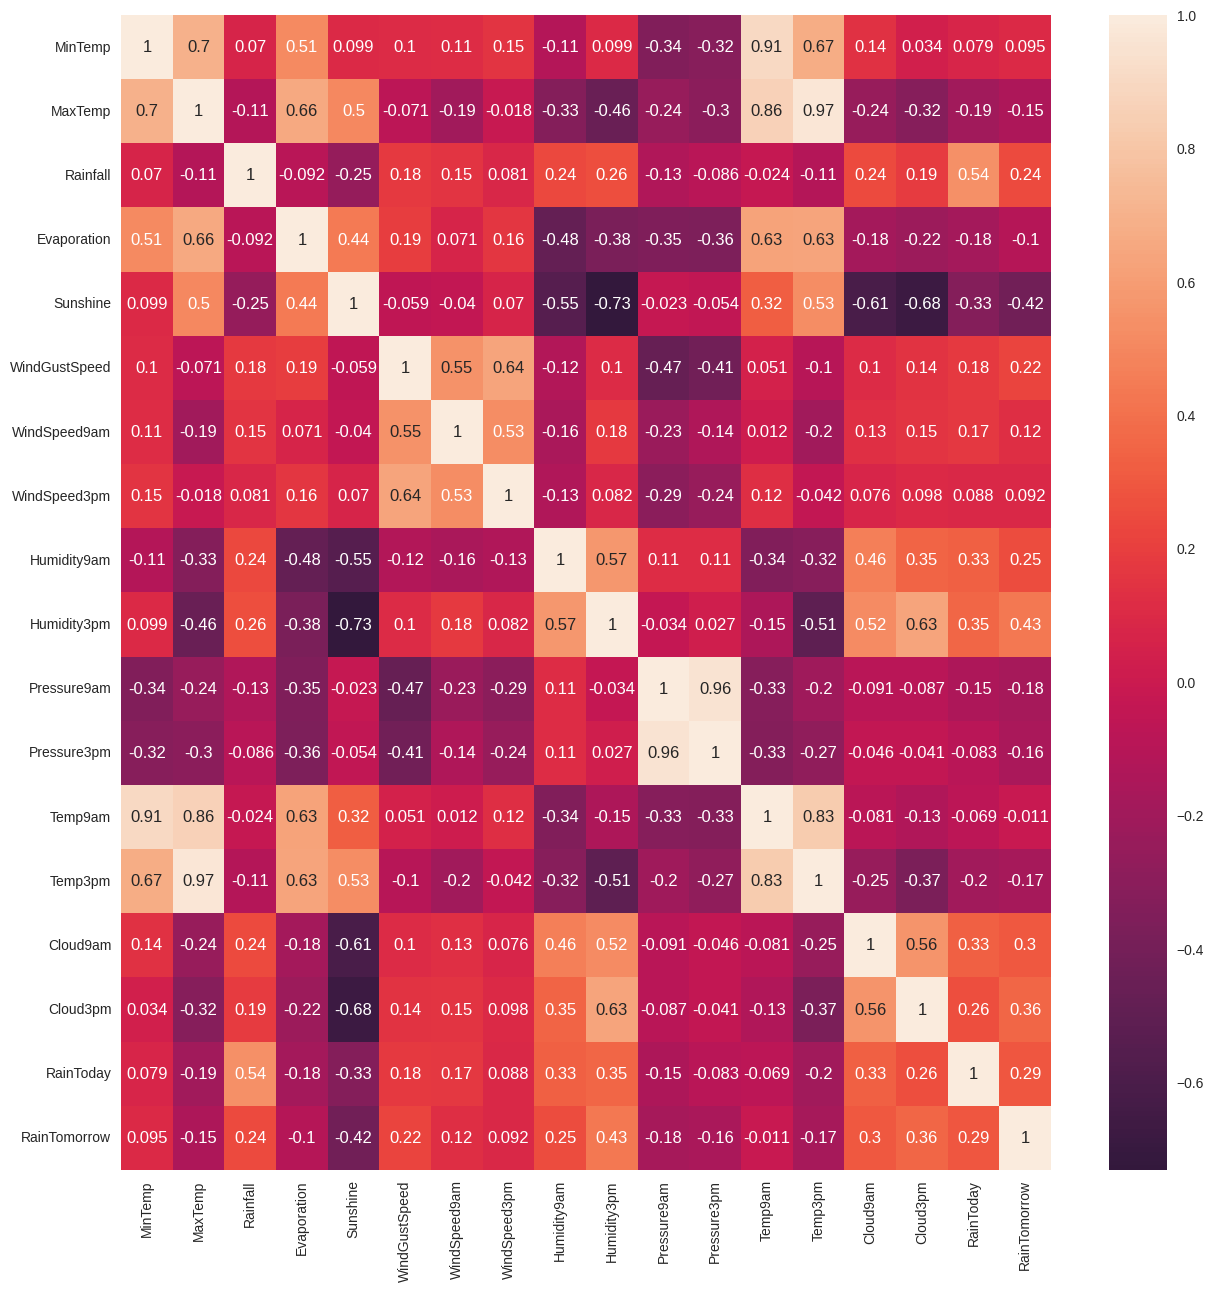

In [43]:
# No inclimos las variables dummies
corr = df_train[["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine",
                 "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am",
                 "Humidity3pm", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm",
                 "Cloud9am", "Cloud3pm", "RainToday", "RainTomorrow"]].corr(method='pearson').round(3)
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="rocket", center=0)
plt.show()

Observando la matriz de correlación podemos notar que existen ciertas variables que están altamente relacionadas.

Por ejemplo, MaxTemp y Temp3pm, y MinTemp y Temp9am. Es de esperar que alguna de estas variables vean sus coeficientes muy minimizados con regularización, debido a su alta colinealidad.

Luego de analizar las relaciones de las variables, verificando cuál es el nivel de correlación de múltiples variables con RainfallTomorrow, e intentamos buscar relaciones adicionales. De esta indagación en el dataset, pudimos encontrar que la variación en un día entre la humedad a las 9 am y 3pm es un buen predictor para la cantidad de lluvia en el día próximo.

In [44]:
#df_train["HumidityChange"] = (df_train["Humidity3pm"] - df_train["Humidity9am"])

# Estandarización

Utilizamos un StandardScaler en las variables numéricas

In [45]:
scaler = StandardScaler()

df_train_numeric = df_train.drop(columns=['WindDir3pmX', 'WindDir3pmY', 'WindDir9amX',
                                          'WindDir9amY', 'WindGustDirX', 'WindGustDirY',
                                          "RainToday", "RainTomorrow",
                                          "Month_2", "Month_3", "Month_4", "Month_5", "Month_6",
                                          "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"
                                          ])

df_train_numeric = pd.DataFrame(scaler.fit_transform(df_train_numeric), columns=df_train_numeric.columns)

df_train = pd.concat([df_train_numeric,
                      df_train[["WindDir3pmX", "WindDir3pmY", "WindDir9amX", "WindDir9amY",
                                "WindGustDirX", "WindGustDirY", "RainToday", "RainTomorrow",
                                "Month_2", "Month_3", "Month_4", "Month_5", "Month_6",
                                "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"]]], axis=1)

df_test_numeric = df_test.drop(columns=['WindDir3pmX', 'WindDir3pmY', 'WindDir9amX',
                                          'WindDir9amY', 'WindGustDirX', 'WindGustDirY',
                                          "RainToday", "RainTomorrow",
                                          "Month_2", "Month_3", "Month_4", "Month_5", "Month_6",
                                          "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"
                                          ])

df_test_numeric = pd.DataFrame(scaler.transform(df_test_numeric), columns=df_test_numeric.columns)

df_test = pd.concat([df_test_numeric,
                      df_test[["WindDir3pmX", "WindDir3pmY", "WindDir9amX", "WindDir9amY",
                               "WindGustDirX", "WindGustDirY", "RainToday", "RainTomorrow",
                               "Month_2", "Month_3", "Month_4", "Month_5", "Month_6",
                               "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"]]], axis=1)

Verifiquemos la distribución de las variables

In [46]:
df_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
count,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,2.419400e+04,...,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000
mean,1.256974e-16,2.179147e-16,2.055799e-17,1.286343e-16,-1.697502e-16,-1.069015e-16,-6.813504e-17,-7.400875e-17,-2.311305e-16,1.314243e-16,...,0.093164,0.078491,0.092957,0.086344,0.083244,0.081301,0.079855,0.083698,0.081962,0.075515
std,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,...,0.290668,0.268948,0.290378,0.280877,0.276256,0.273303,0.271073,0.276941,0.274313,0.264225
min,-3.202180e+00,-3.879076e+00,-3.077021e-01,-1.790519e+00,-2.175396e+00,-2.350187e+00,-1.342219e+00,-1.844356e+00,-3.924049e+00,-2.678010e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.603257e-01,-5.589438e-01,-3.077021e-01,-7.385196e-01,-7.139365e-01,-6.840472e-01,-6.832429e-01,-6.478074e-01,-6.247888e-01,-7.048543e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.181172e-01,-2.015047e-02,-3.077021e-01,-1.974913e-01,1.161231e-01,-1.769612e-01,-1.340959e-01,-8.216603e-02,5.781673e-02,-1.424980e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.853539e-01,5.768908e-01,-2.126710e-01,5.990224e-01,7.506028e-01,4.750065e-01,5.248805e-01,5.487417e-01,7.404223e-01,7.256836e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.866497e+00,3.649469e+00,2.538633e+01,2.631289e+01,2.229002e+00,6.922243e+00,1.293560e+01,7.184150e+00,1.593679e+00,2.156222e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Definimos X e y

In [47]:
X_train_full = df_train.drop(columns=["RainTomorrow"])
y_train_full = df_train["RainTomorrow"]

X_test = df_test.drop(columns=["RainTomorrow"])
y_test = df_test["RainTomorrow"]

# Ahora, creamos conjuntos de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)  # 20% de validación, 80% de entrenamiento

In [48]:
X_train_full["Rainfall"].value_counts()

,count
Rainfall,
-0.307702,15076
-0.283944,1633
-0.260187,616
-0.236429,439
-0.188913,333
...,...
8.363884,1
9.599288,1
6.867144,1


# Regresión logística

In [ ]:
warnings.filterwarnings('ignore')
model = LogisticRegression(random_state=42, max_iter=1, warm_start=True)
LogisticRegression
# Number of epochs
epochs = 200

# Lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Fit the model for one iteration
    model.fit(X_train, y_train)

    # Predict probabilities
    y_train_pred = model.predict_proba(X_train)
    y_val_pred = model.predict_proba(X_val)

    # Calculate log loss for both training and validation
    train_loss = log_loss(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred)

    # Append to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

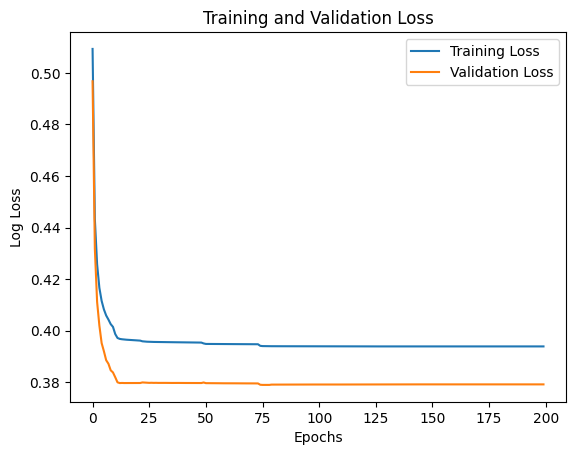

In [ ]:
# Plot the losses
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

El modelo parece estabilizarse a partir de aproximadamente 105 epocas, y no parece haber presencia de overfitting.

In [ ]:
logisticRegModel = LogisticRegression()

logisticRegModel.fit(X_train, y_train)

y_pred = logisticRegModel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      4630
         1.0       0.68      0.44      0.53      1419

    accuracy                           0.82      6049
   macro avg       0.76      0.69      0.71      6049
weighted avg       0.81      0.82      0.81      6049



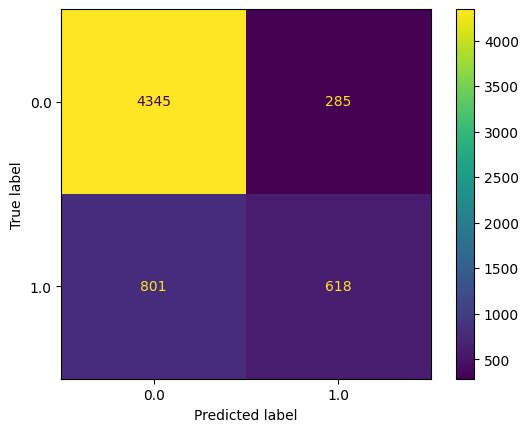

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

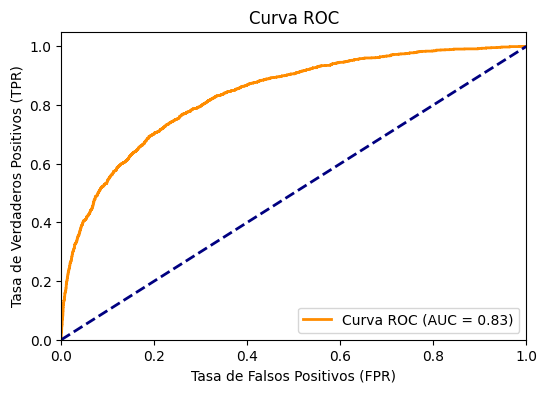

In [ ]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logisticRegModel.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Consideramos que un buen valor en este problema sería uno que tenga la menor cantidad de falsos negativos (días que llovieron y predijimos que no llovería), ya que consideramos que en el mundo real, el peor caso posible sería predecir que no llovería y que llueva.

Sin embargo, claramente hay que conseguir un balance, ya que con esta regla, simplemente predecir que llueve siempre sería una solución "óptima", pero que no aportaría ningún valor.

Veamos los thresholds a los que equivalen los valores de la curva roc

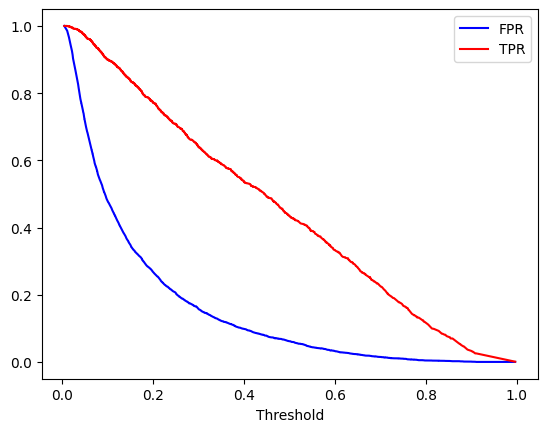

In [ ]:
# plot fpr and tpr by thresholds
plt.plot(thresholds, fpr, color='blue', label='FPR')
plt.plot(thresholds, tpr, color='red', label='TPR')
plt.legend()
plt.xlabel('Threshold')
plt.show()

Observándo el gráfico anterior, tenemos que si utilizamos un threshold de 0.5, tendremos un FPR de ~0.1, y un TPR de ~0.5. Como dijimos, lo ideal sería minimizar los Falsos Negativos (o maximizar los Verdaderos Positivos), por lo que un 50% de tasa de error no sería deseable.

Un buen threshold, con esta consideración, sería de aproximadamente 0.2. En este tendremos un TPR de ~0.8, lo cual es relativamente alto, sin que nuestro FPR sea demasiado alto. De hecho, se nota como esta curva comienza a crecer exponencialmente a luego de este punto.

In [ ]:
indice_threshold_ideal = np.abs(thresholds - 0.2).argmin()
fpr[indice_threshold_ideal], tpr[indice_threshold_ideal]

(0.2680345572354212, 0.7730796335447498)

# Modelo Base

Como modelo base, podemos utilizar las variables de mayor correlación según la matriz de correlación.

Utilizaremos las variables con correlación > 0.3:
- `Sunshine`
- `Humidity3pm`
- `Cloud3pm`

Luego, si las nubes y humedad superan un cierto umbral (la media) y la cantidad de sol es menor a cierto otro umbral (1er cuartil), prediciremos que mañana lloverá, y en caso contrario, que no.


In [ ]:
df_train[["Sunshine", "Humidity3pm", "Cloud3pm", "RainToday"]].describe()

,Sunshine,Humidity3pm,Cloud3pm,RainToday
count,2.419400e+04,2.419400e+04,2.419400e+04,24194.000000
mean,-1.697502e-16,4.458146e-16,-1.923640e-16,0.232454
std,1.000021e+00,1.000021e+00,1.000021e+00,0.422406
min,-2.175396e+00,-2.678002e+00,-2.021027e+00,0.000000
25%,-7.139365e-01,-7.048427e-01,-7.272869e-01,0.000000
50%,1.161231e-01,-1.423678e-02,1.352061e-01,0.000000
75%,7.506028e-01,7.256981e-01,9.976992e-01,0.000000
max,2.229002e+00,2.156239e+00,1.428946e+00,1.000000


In [ ]:
umbral_humedad = df_train["Humidity3pm"].median()
umbral_nubes = df_train["Cloud3pm"].median()
umbral_sol = df_train["Sunshine"].quantile(0.25)
umbral_lluvia = 1

def basemodel_selector(sunshine, humidity3pm, cloud3pm, RainToday):
    return int(humidity3pm > umbral_humedad and cloud3pm > umbral_nubes and sunshine < umbral_sol)

print(umbral_humedad, umbral_nubes, umbral_sol, umbral_lluvia)

-0.014236778367284342 0.13520614321969643 -0.7139365375220957 1


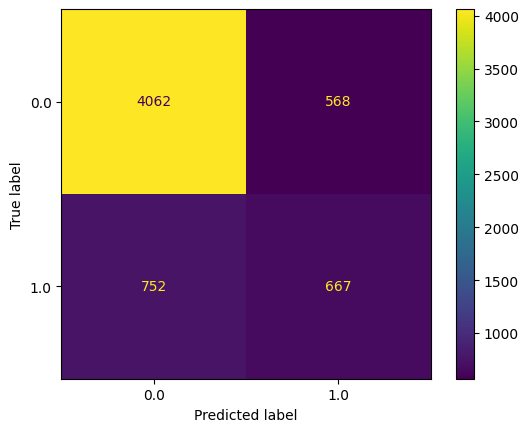

In [ ]:
y_pred = X_test.apply(lambda row: basemodel_selector(row["Sunshine"], row["Humidity3pm"], row["Cloud3pm"], row["RainToday"]), axis=1)

# confussion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      4630
         1.0       0.54      0.47      0.50      1419

    accuracy                           0.78      6049
   macro avg       0.69      0.67      0.68      6049
weighted avg       0.77      0.78      0.78      6049



Vemos que nuestro modelo tiene un performance inferior al de la regresión logística. Es claro que nuestro modelo funciona bastante mejor que el azar para predecir días sin lluvia pero es peor para predecir días de lluvia.

Además, es menos flexible al no estar prediciendo probabilidades, y por lo tanto no poder ajustar un umbral de decisión.

No consideramos haber conseguido un buen fitting: para empezar, tenemos un modelo peor en todas las métricas al conseguido con la regresión logística. Nuestro modelo no es capaz de predecir la lluvia en más del 50% de los días en los que llueve. Claramente si ajustamos los umbrales que elegimos podríamos intentar mejorar este modelo, pero a costa de peores predicciones para la clase 0.

# Tunning de Hiperparámetros

Realizaremos grid search con validación cruzada con k-folds.

Utilizaremos los siguientes parámetros:
- `penalty`: Podemos elegir diferentes tipos de regularización, como Ridge, Lasso o Elasticnet.
- `C`: Probamos diferentes pesos de regularización.
- `solver`: Podemos elegir diferentes solvers, como liblinear, newton-cg, lbfgs, sag o saga. Diferentes solvers son mejores para datasets de diferentes tamaños y características, y soportan diferentes tipos de regularización.
- `max_iter`: Elegir una diferente cantidad de iteraciones puede ser bueno para evitar overfitting.
- `class_weight`: Pues nuestro conjunto de datos está desbalanceado.

In [ ]:
warnings.filterwarnings('ignore')

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 300],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, verbose=0), param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train_full, y_train_full)

/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mint/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Convergen

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [50, 100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='balanced_accuracy')

Veamos los mejores parámetros y su performance

In [ ]:
grid_search.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 50,
 'penalty': 'l1',
 'solver': 'saga'}

Llama la atención que el mínimo error se encuentra utilizando tan solo 50 operaciones, mientras que en el primer modelo que hicimos, el error de validación mejoraba hasta aproximadamente las 100 iteraciones, y nunca parecía overfittear.

              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84      4630
         1.0       0.50      0.73      0.59      1419

    accuracy                           0.77      6049
   macro avg       0.70      0.75      0.72      6049
weighted avg       0.81      0.77      0.78      6049



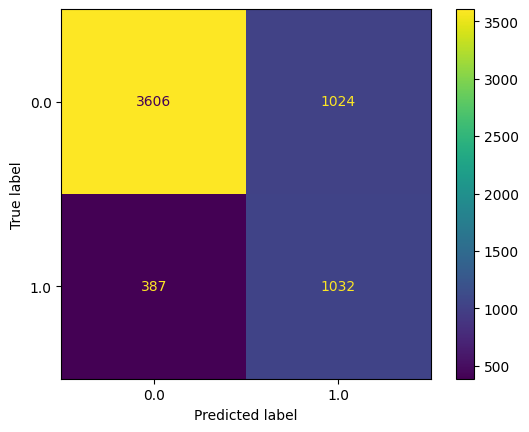

In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

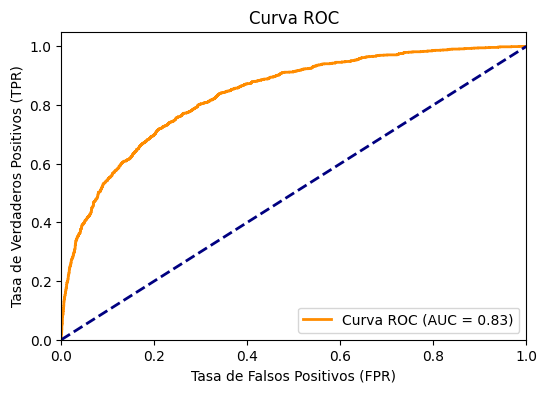

In [ ]:
# Obtengo las probabilidades de predicción del modelo
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Observamos que el performance general no parece mejorar demasiado, con un AUC igual al obtenido en el modelo de la sección anterior.

Veamos los thresholds a los que equivalen los valores de la curva roc

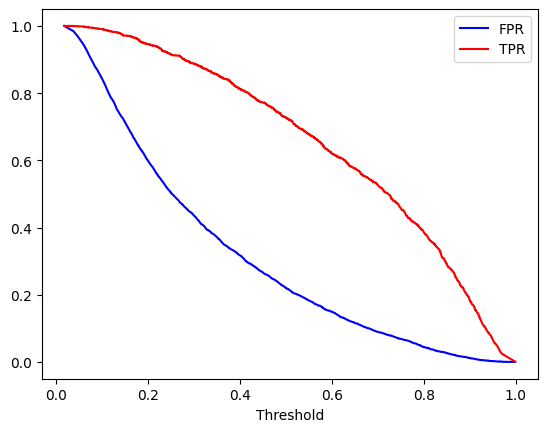

In [ ]:
# plot fpr and tpr by thresholds
plt.plot(thresholds, fpr, color='blue', label='FPR')
plt.plot(thresholds, tpr, color='red', label='TPR')
plt.legend()
plt.xlabel('Threshold')
plt.show()

Notamos que el modelo tiene un TRP mayor para todos los thresholds, lo cual es deseable en nuestro problema. Sin embargo, esto no es sin tener un FPR mayor.

In [ ]:
indice_threshold_ideal = np.abs(thresholds - 0.45).argmin()
fpr[indice_threshold_ideal], tpr[indice_threshold_ideal]

(0.26846652267818577, 0.7723749119097957)

El performance parece exactamente igual.

En conclusión, el modelo resultante del grid search, en este caso, mejoró el recall del modelo (que es lo que buscamos priorizar) para el umbral predeterminado de 0.5. Sin embargo, una vez ajustamos el umbral de decisión al que definimos como "óptimo", no se encuentra una diferencia significativa entre los dos modelos, por lo que nuestro modelo no se vio beneficiado.

Ahora, veamos

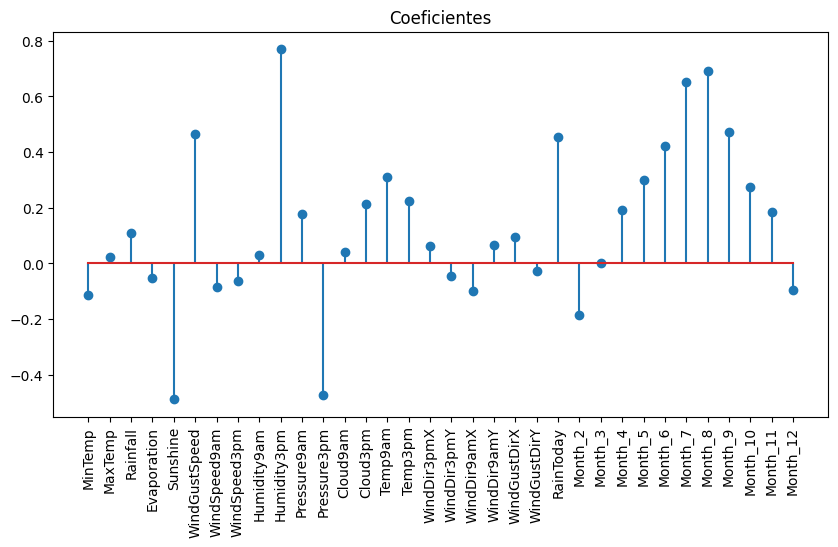

In [ ]:
# Graficamos los coeficientes
plt.figure(figsize=(10, 5))
plt.stem(X_train_full.columns, best_model.coef_[0])
plt.xticks(rotation=90)
plt.title('Coeficientes')
plt.show()

# Explicabilidad con SHAP

## Explicabilidad global

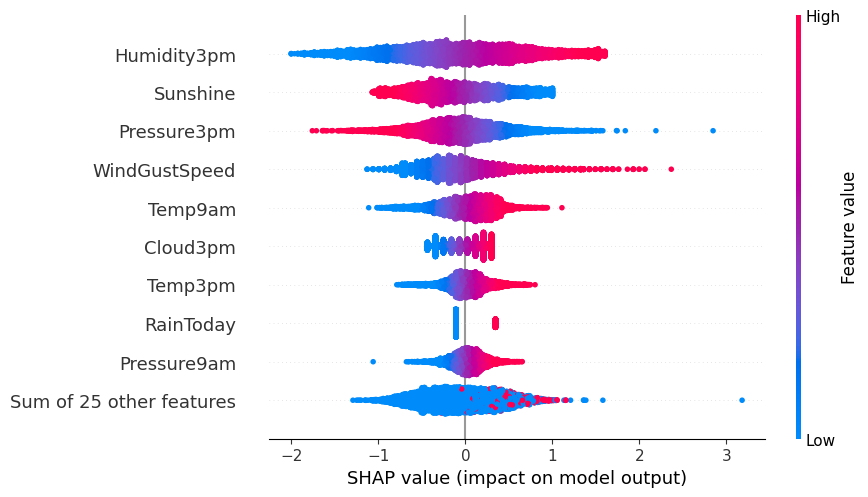

In [ ]:
variables_prediccion = df_train.drop("RainTomorrow", axis=1).columns

explainer = shap.Explainer(best_model, X_train, feature_names=variables_prediccion)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

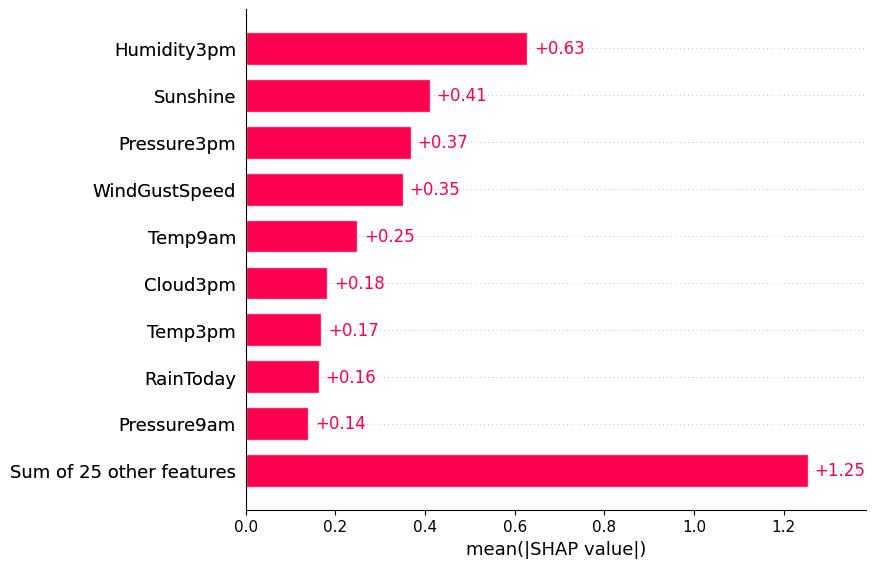

In [ ]:
shap.plots.bar(shap_values)

Vemos que las variables que mayor importancia le da el modelo a la hora de predecir si lloverá o no son:

- Humedad a las 3pm
- La cantidad de luz de sol
- Presión a las 3pm
- La velocidad del viento
- Si llovió el día anterior

Resulta interesante ver que, a pesar de la presencia de valores muy remotos en la variable, la velocidad del viento recibe un gran peso a la hora de decidir para el modelo, aumentando mucho las probabilidades de lluvia. Además, parece contraintuitivo que nuestro modelo prediga que a más presión a las 3pm, menor será la probabilidad de que llueva mañana.

Finalmente, resulta interesante observar que SHAP, para el caso de la regresión logística, los valores que más aportan a SHAP coinciden con los valores que mayores coeficientes tienen para la regresión logística. Esto tiene sentido pues nuestro modelo le asigna importancia a los atributos a través de sus coeficientes. Entonces, a partir de estos resultados, la magnitud del coeficiente representa a su vez la importancia que se le da a la hora de predecir.

## Explicabilidad local

Veamos algunas predicciones en particular.

In [ ]:
ind = y_test.idxmax()

print(X_test.loc[ind].to_dict(), "\n", y_test[ind])

shap.initjs()
shap.plots.force(shap_values[ind])

{'MinTemp': 0.05449789145085403, 'MaxTemp': -0.4132733174161475, 'Rainfall': 3.9211808160847847, 'Evaporation': -0.4830340107307621, 'Sunshine': 0.27628303531858733, 'WindGustSpeed': -0.7708687455213423, 'WindSpeed9am': 0.30521225376574257, 'WindSpeed3pm': -0.21284843669476156, 'Humidity9am': -0.2831864513583119, 'Humidity3pm': 0.28173717043524327, 'Pressure9am': 0.6368491497017587, 'Pressure3pm': 0.7369571780612553, 'Cloud9am': 1.0492435967414597, 'Cloud3pm': 0.566452673271815, 'Temp9am': 0.19282294508879683, 'Temp3pm': -0.25590670096671214, 'WindDir3pmX': 1.4142135623730951, 'WindDir3pmY': -1.4142135623730951, 'WindDir9amX': 1.4142135623730951, 'WindDir9amY': -1.4142135623730951, 'WindGustDirX': 0.3784698805006562, 'WindGustDirY': 0.39108193250385836, 'RainToday': 1.0, 'Month_2': 0.0, 'Month_3': 0.0, 'Month_4': 0.0, 'Month_5': 0.0, 'Month_6': 1.0, 'Month_7': 0.0, 'Month_8': 0.0, 'Month_9': 0.0, 'Month_10': 0.0, 'Month_11': 0.0, 'Month_12': 0.0} 
 1.0


Notamos que esta observación resulta ser uno de los valores remotos de `WindGustSpeed` con un valor de

In [ ]:
ind = y_test.idxmin()

print(y_test[ind])

shap.initjs()
shap.plots.force(shap_values[ind])

0.0


Vemos que en explicabilidad local, se replican los resultados obtenidos en la explicabilidad global.

# Modelo AutoML

In [49]:
exp_clf = setup(data=df_train, target='RainTomorrow', session_id=123)

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(24194, 35)"
4,Transformed data shape,"(24194, 35)"
5,Transformed train set shape,"(16935, 35)"
6,Transformed test set shape,"(7259, 35)"
7,Numeric features,34
8,Preprocess,True
9,Imputation type,simple


In [50]:
# Lo deseable es usar como metrica maximizar el recall de la clase 1

best_model = exp_clf.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8411,0.8550,0.4883,0.7384,0.5877,0.4943,0.5106,4.1310
lightgbm,Light Gradient Boosting Machine,0.8408,0.8604,0.5061,0.7250,0.5959,0.5007,0.5133,1.5110
et,Extra Trees Classifier,0.8389,0.8577,0.4463,0.7604,0.5624,0.4718,0.4970,1.7320
xgboost,Extreme Gradient Boosting,0.8385,0.8545,0.5219,0.7055,0.5998,0.5015,0.5105,0.5190
rf,Random Forest Classifier,0.8382,0.8541,0.4595,0.7459,0.5685,0.4758,0.4970,2.8650
lr,Logistic Regression,0.8299,0.8421,0.4758,0.6948,0.5647,0.4636,0.4765,0.7340
ada,Ada Boost Classifier,0.8298,0.8383,0.4733,0.6961,0.5634,0.4625,0.4758,1.0500
lda,Linear Discriminant Analysis,0.8298,0.8405,0.4997,0.6818,0.5766,0.4733,0.4823,0.1110
ridge,Ridge Classifier,0.8288,0.8405,0.4290,0.7198,0.5373,0.4405,0.4628,0.0550
knn,K Neighbors Classifier,0.8231,0.7972,0.4623,0.6734,0.5481,0.4428,0.4550,0.3440


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Luego de haber corrido todos los modelos, vemos lo siguiente:
- Si quisieramos maximizar el Recall como la métrica más importante como veníamos haciendo hasta ahora, el mejor modelo -con una ventaja significativa- es el de `Naive Bayes`.
- Sin embargo, existen dos modelos que tienen métricas excepcionalmente buenas comparado con los demás: `Gradient Boosting Classifier` y `Light Gradient Boosting Machine`.


`Gradient Boosting Classifier` combina múltiples árboles de decisión débiles iterativamente. Al ser un modelo ensamble, quizás alguno de los modelos que incluye resultó muy apropiado en el problema que se nos presentó. Esto además llama la atención ya que el modelo `Decision Tree Classifier` es el modelo con las peores métricas que se encontró, con un Accuracy menor que el dummy.

Por otro lado, `Light Gradient Boosting Machine` no es más que un framework open-source para hacer Gradient Boosting.

Pudemos ver cómo AutoML permite encontrar modelos con un buen performance sin realizar un trabajo arduo, dando métricas en forma de reporte, incluso permitiendo su comparación de forma fácil e intuitiva.

La barrera de entrada es de hecho tan baja que tuvimos que buscar algunos de los modelos que obtuvieron las mejores métricas y hacernos una idea de por qué tienen un mejor rendimiento. A pesar de esto, fuimos capaces de usar AutoML sin mayores problemas.